In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv1D,Conv2D,BatchNormalization,MaxPooling1D,MaxPooling2D,Reshape
from keras.utils import to_categorical
from keras import regularizers
from keras.regularizers import l1,l2
from keras import initializers
import matplotlib.pyplot as plt

In [2]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

### Shape of data

In [3]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


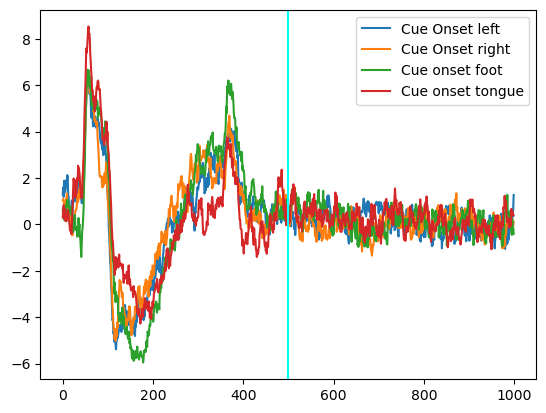

In [4]:
## Loading and visualizing the data


# Adjusting the labels so that 
# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [5]:
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 500, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))


# Creating the training and validation sets using the generated indices
x_train = X_train_valid[ind_train]
y_train = y_train_valid[ind_train]

x_valid = X_train_valid[ind_valid]
y_valid = y_train_valid[ind_valid]

print('Shape of training set:', x_train.shape)
print('Shape of validation set:', x_valid.shape)
print('Shape of training labels:', y_train.shape)
print('Shape of validation labels:', y_valid.shape)


# Preprocessing the dataset
x_train = x_train[:, :, 0:500]
x_valid = x_valid[:, :, 0:500]
x_test = X_test[:, :, 0:500]

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)


# Convert labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
print('Shape of training labels after categorical conversion:', y_train.shape)

y_valid = to_categorical(y_valid, 4)
print('Shape of validation labels after categorical conversion:', y_valid.shape)

y_test = to_categorical(y_test, 4)
print('Shape of test labels after categorical conversion:', y_test.shape)


# Add width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)


# Reshape the training and validation dataset
x_train = np.swapaxes(x_train, 1, 3)
x_train = np.swapaxes(x_train, 1, 2)
x_train = x_train[:, :, 0, :]
print('Shape of training set after dimension reshaping:', x_train.shape)

x_valid = np.swapaxes(x_valid, 1, 3)
x_valid = np.swapaxes(x_valid, 1, 2)
x_valid = x_valid[:, :, 0, :]
print('Shape of validation set after dimension reshaping:', x_valid.shape)

x_test = np.swapaxes(x_test, 1, 3)
x_test = np.swapaxes(x_test, 1, 2)
x_test = x_test[:, :, 0, :]
print('Shape of test set after dimension reshaping:', x_test.shape)

Shape of training set: (1615, 22, 1000)
Shape of validation set: (500, 22, 1000)
Shape of training labels: (1615,)
Shape of validation labels: (500,)
(1615, 22, 500)
(1615,)
(500, 22, 500)
(500,)
(443, 22, 500)
(443,)
Shape of training labels after categorical conversion: (1615, 4)
Shape of validation labels after categorical conversion: (500, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after dimension reshaping: (1615, 500, 22)
Shape of validation set after dimension reshaping: (500, 500, 22)
Shape of test set after dimension reshaping: (443, 500, 22)


In [6]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv1D(filters=15, kernel_size=5, padding='same',\
                           activation='elu', input_shape=(500,22)))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(MaxPooling1D(pool_size=3, padding='same')) # Read the keras documentation
basic_cnn_model.add(Dropout(0.3))

# Conv. block 2
basic_cnn_model.add(Conv1D(filters=25, kernel_size=5, padding='same',\
                           activation='elu'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(MaxPooling1D(pool_size=3, padding='same'))
basic_cnn_model.add(Dropout(0.3))

# Conv. block 3
basic_cnn_model.add(Conv1D(filters=75, kernel_size=5, padding='same',\
                           activation='elu'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(MaxPooling1D(pool_size=3, padding='same'))
basic_cnn_model.add(Dropout(0.3))

# Conv. block 4
basic_cnn_model.add(Conv1D(filters=90, kernel_size=5, padding='same',\
                           activation='elu'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(MaxPooling1D(pool_size=3, padding='same'))
basic_cnn_model.add(Dropout(0.3))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax', kernel_regularizer=regularizers.L1(l1=0.01))) # Output FC layer with softmax activation

# Printing the model summary
basic_cnn_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 500, 15)           1665      
                                                                 
 batch_normalization (Batch  (None, 500, 15)           60        
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 167, 15)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 167, 15)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 167, 25)           1900      
                                                                 
 batch_normalization_1 (Bat  (None, 167, 25)          

In [7]:
# Model parameters
learning_rate = 1e-3
epochs = 100
cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

In [8]:
# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/100



26/26 [==============================] - 4s 40ms/step - loss: 3.2305 - accuracy: 0.2718 - val_loss: 2.5739 - val_accuracy: 0.3800
Epoch 2/100
26/26 [==============================] - 1s 21ms/step - loss: 2.7793 - accuracy: 0.3430 - val_loss: 2.3178 - val_accuracy: 0.4080
Epoch 3/100
26/26 [==============================] - 1s 20ms/step - loss: 2.5660 - accuracy: 0.3678 - val_loss: 2.1804 - val_accuracy: 0.4200
Epoch 4/100
26/26 [==============================] - 1s 21ms/step - loss: 2.3527 - accuracy: 0.3820 - val_loss: 2.1897 - val_accuracy: 0.3760
Epoch 5/100
26/26 [==============================] - 1s 21ms/step - loss: 2.1942 - accuracy: 0.3820 - val_loss: 1.9740 - val_accuracy: 0.4540
Epoch 6/100
26/26 [==============================] - 1s 20ms/step - loss: 2.0208 - accuracy: 0.4192 - val_loss: 1.8988 - val_accuracy: 0.4560
Epoch 7/100
26/26 [==============================] - 1s 21ms/step - loss: 1.8853 - accuracy: 0.4563 - val_loss: 1.8199 - val_accuracy: 0.4480
Epoch 8/100
26/26 

26/26 [==============================] - 1s 24ms/step - loss: 0.8497 - accuracy: 0.7325 - val_loss: 0.9652 - val_accuracy: 0.6900
Epoch 59/100
26/26 [==============================] - 1s 28ms/step - loss: 0.8673 - accuracy: 0.7226 - val_loss: 0.9844 - val_accuracy: 0.6800
Epoch 60/100
26/26 [==============================] - 1s 24ms/step - loss: 0.8457 - accuracy: 0.7368 - val_loss: 0.9637 - val_accuracy: 0.6900
Epoch 61/100
26/26 [==============================] - 1s 28ms/step - loss: 0.8295 - accuracy: 0.7381 - val_loss: 0.9637 - val_accuracy: 0.6680
Epoch 62/100
26/26 [==============================] - 1s 38ms/step - loss: 0.8092 - accuracy: 0.7492 - val_loss: 0.9617 - val_accuracy: 0.6820
Epoch 63/100
26/26 [==============================] - 1s 36ms/step - loss: 0.8257 - accuracy: 0.7467 - val_loss: 0.9467 - val_accuracy: 0.6960
Epoch 64/100
26/26 [==============================] - 1s 27ms/step - loss: 0.7888 - accuracy: 0.7610 - val_loss: 0.9524 - val_accuracy: 0.7020
Epoch 65/100

In [9]:
## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.7133182883262634


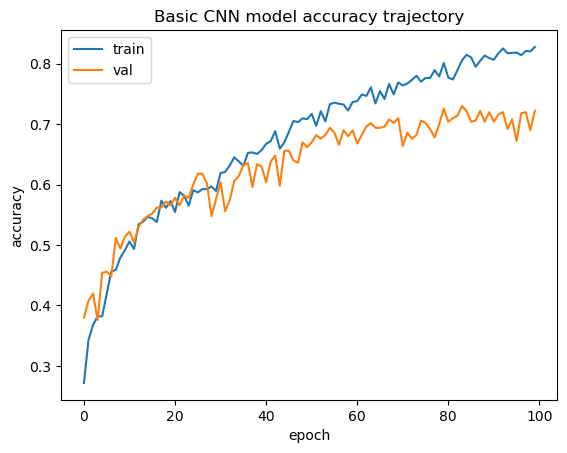

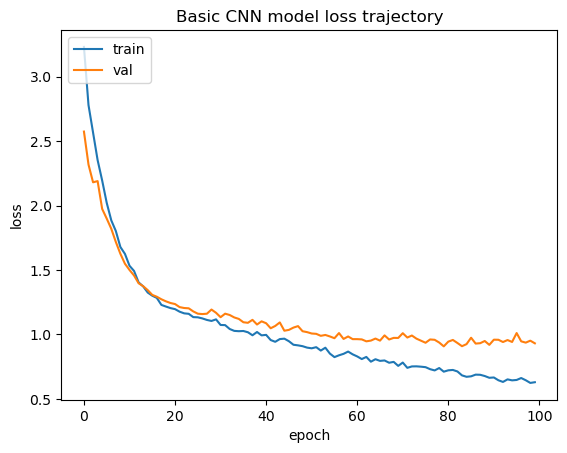

In [10]:
# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'])
plt.plot(basic_cnn_model_results.history['val_loss'])
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()